In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt
/kaggle/input/human-stress-prediction/Stress.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import pad_sequences

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# **IMPORTING THE DATASET**

In [4]:
data = pd.read_csv("/kaggle/input/human-stress-prediction/Stress.csv")

# **DATA VISUALIZATION AND PREPROCESSING**

In [5]:
data.head()

subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text  label  confidence  \
0  He said he had not felt that way before, sugge...      1         0.8   
1  Hey there r/assistance, Not sure if this is th...      0         1.0   
2  My mom then hit me with the newspaper and it s...      1         0.8   
3  until i met my new boyfriend, he is amazing, h...      1         0.6   
4  October is Domestic Violence Awareness Month a...      1         0.8   

   social_timestamp  
0        1521614353  
1        1527009817  
2        1535935605  
3        1516429555  
4        1539809005

Text(0.5, 1.0, 'Distribution of Labels')

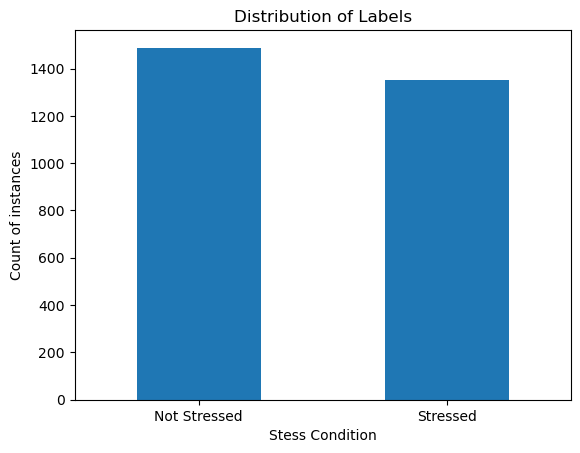

In [6]:
ax = data.label.value_counts().plot(kind='bar')
ax.set_xticks(ticks=[1,0],labels=['Stressed','Not Stressed'],rotation=0)
plt.ylabel('Count of instances')
plt.xlabel('Stess Condition')
plt.title('Distribution of Labels')          

In [7]:
data.isna().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [8]:
data.subreddit.value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

[Text(0, 0, 'Not Stressed'), Text(1, 0, 'Stressed')]

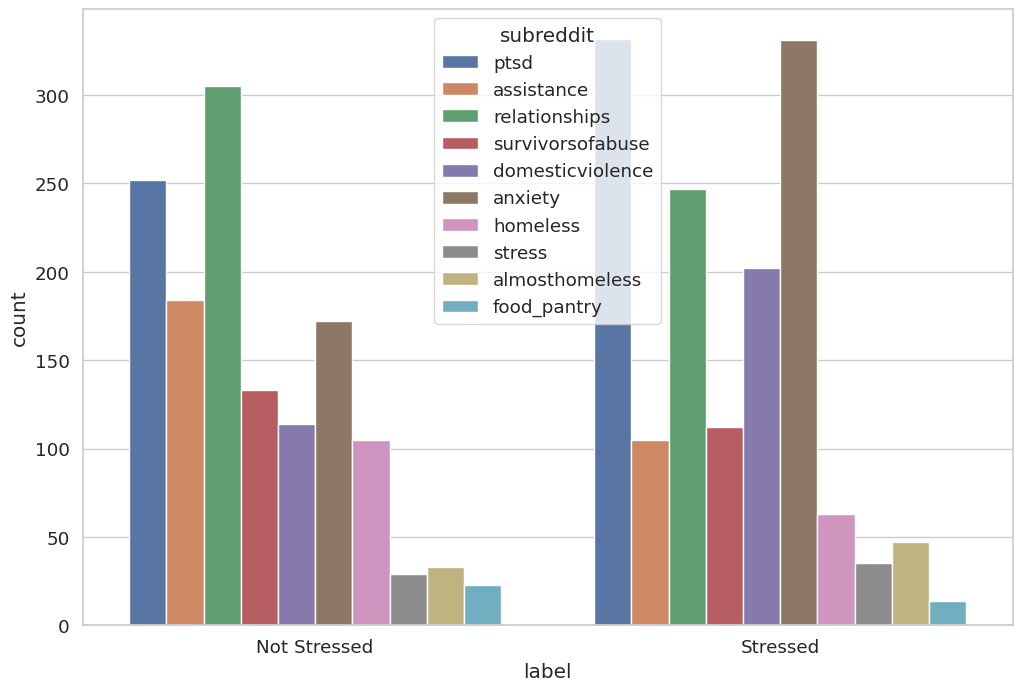

In [9]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "label", hue = "subreddit" , data = data)
#chart.set_xticklabels(chart.get_xticklabels(),rotation=0)
chart.set_xticklabels(labels=['Not Stressed','Stressed'],rotation=0)

In [10]:
data['text'] =data['subreddit'] + ' '+ data['text']

# WHAT ARE STOPWORDS?

##### Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.

In [11]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [12]:
#Removing the stopwords from text
wnl = WordNetLemmatizer()
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
data["text"] = data["text"].apply(remove_stopwords)

#lemmatization. That is, we get the roots of the words
data["text"] = data["text"].apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))

# **Wordcloud**
### For stressed condition

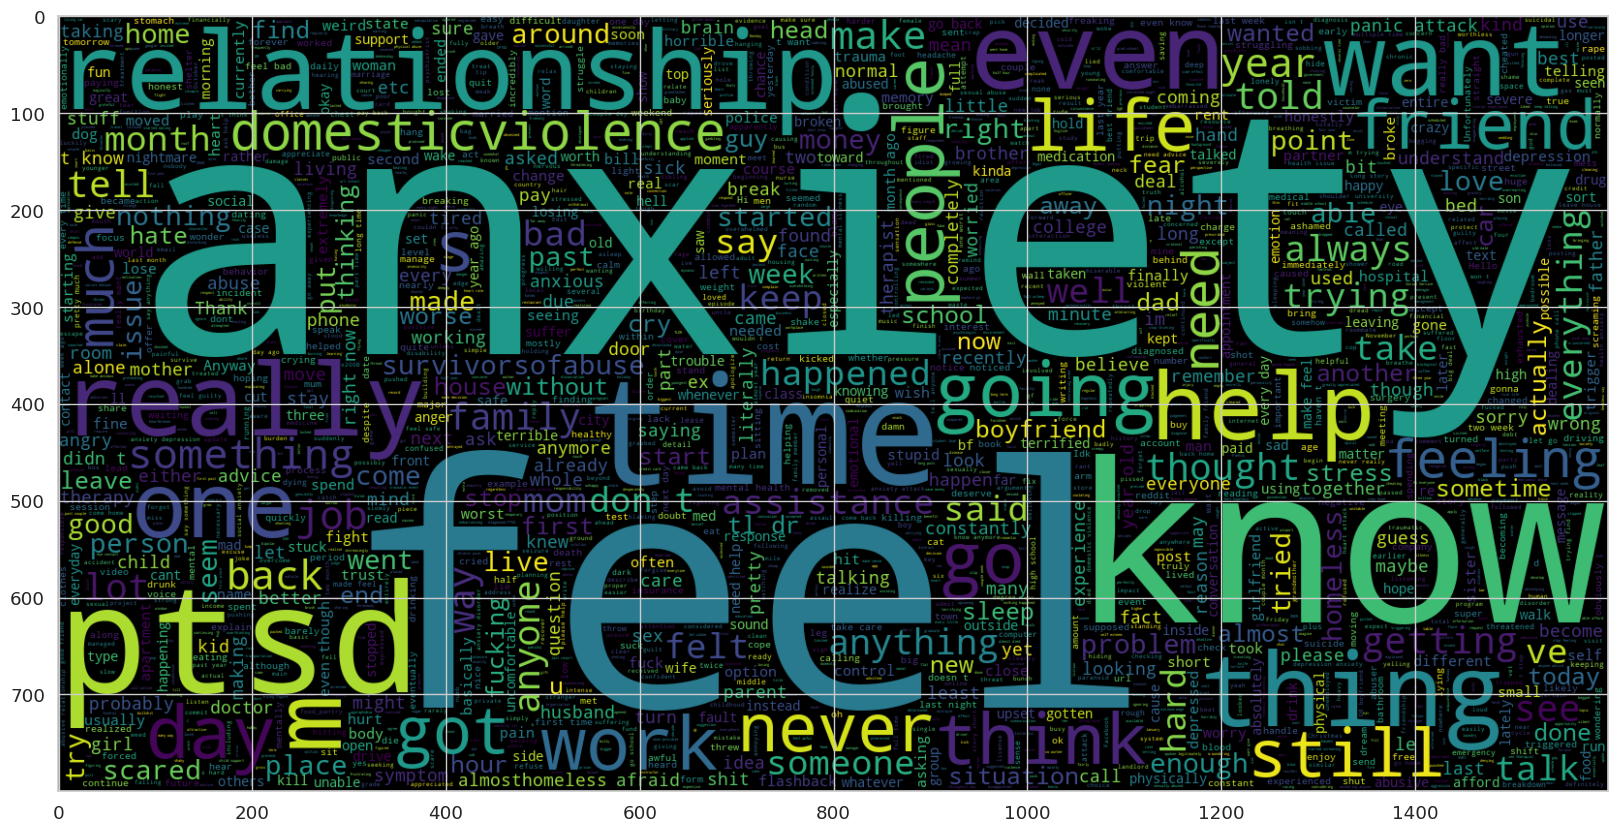

In [13]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

### For non-stressed condition

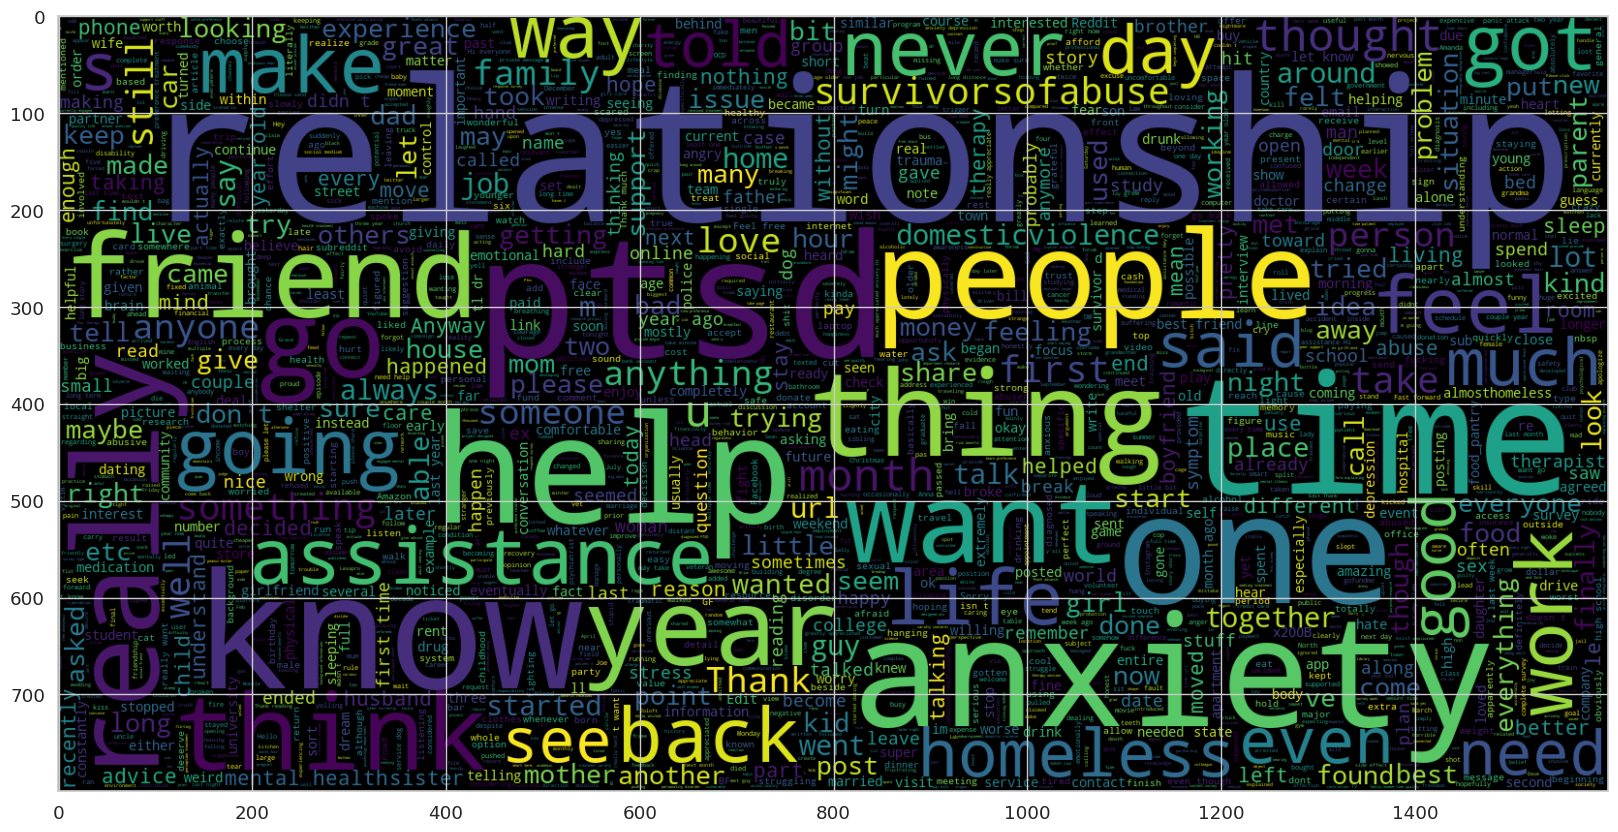

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# **Number of characters in texts**

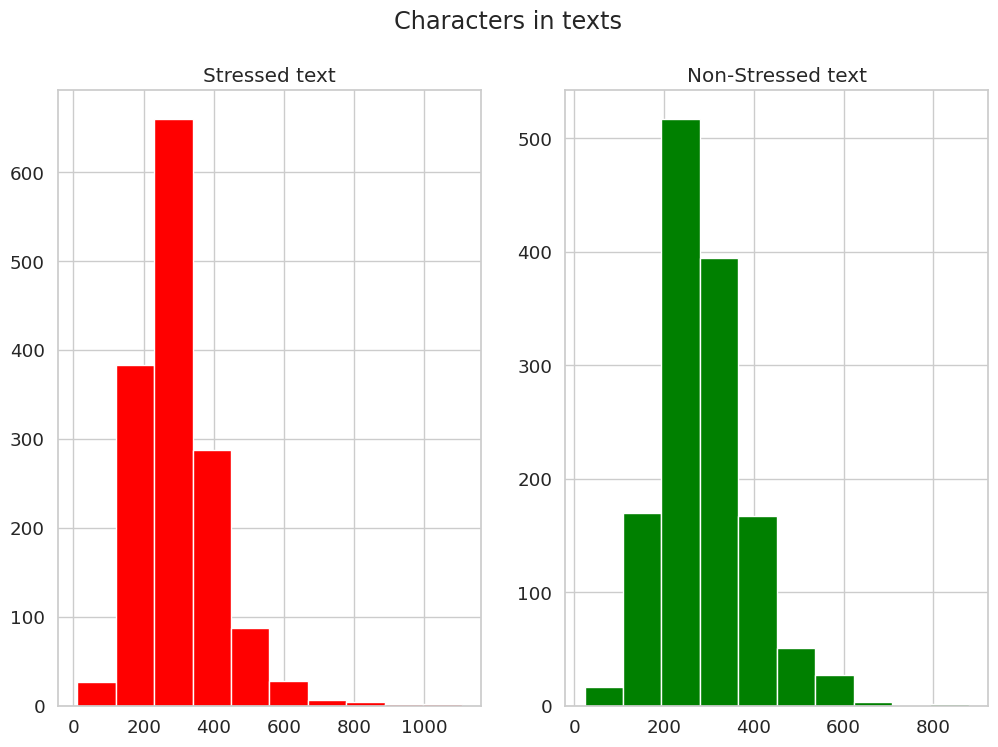

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Stressed text')
text_len=data[data['label']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Non-Stressed text')
fig.suptitle('Characters in texts')
plt.show()

### **Number of words in each text**

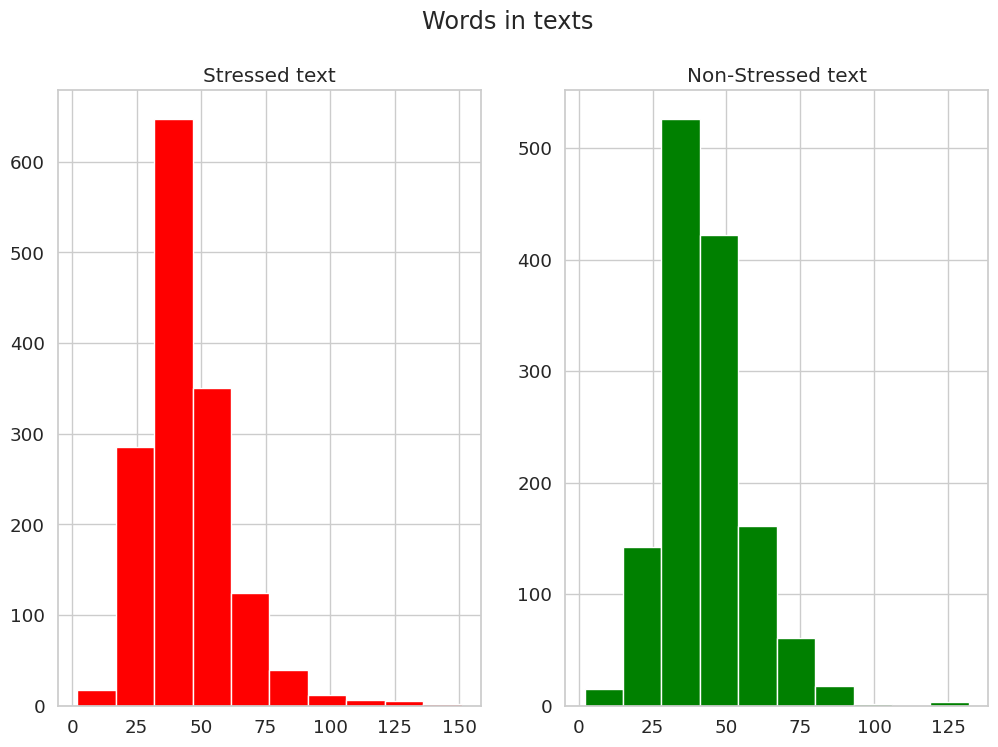

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Stressed text')
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Non-Stressed text')
fig.suptitle('Words in texts')
plt.show()

In [17]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.text)
corpus[:5]

['ptsd', 'said', 'felt', 'way', 'before,']

In [18]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{"I'm": 1201,
 'like': 1122,
 'get': 905,
 'feel': 828,
 'know': 819,
 'anxiety': 797,
 'relationship': 751,
 'would': 737,
 'time': 666,
 'want': 629}

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# **Unigram Analysis**

<AxesSubplot:>

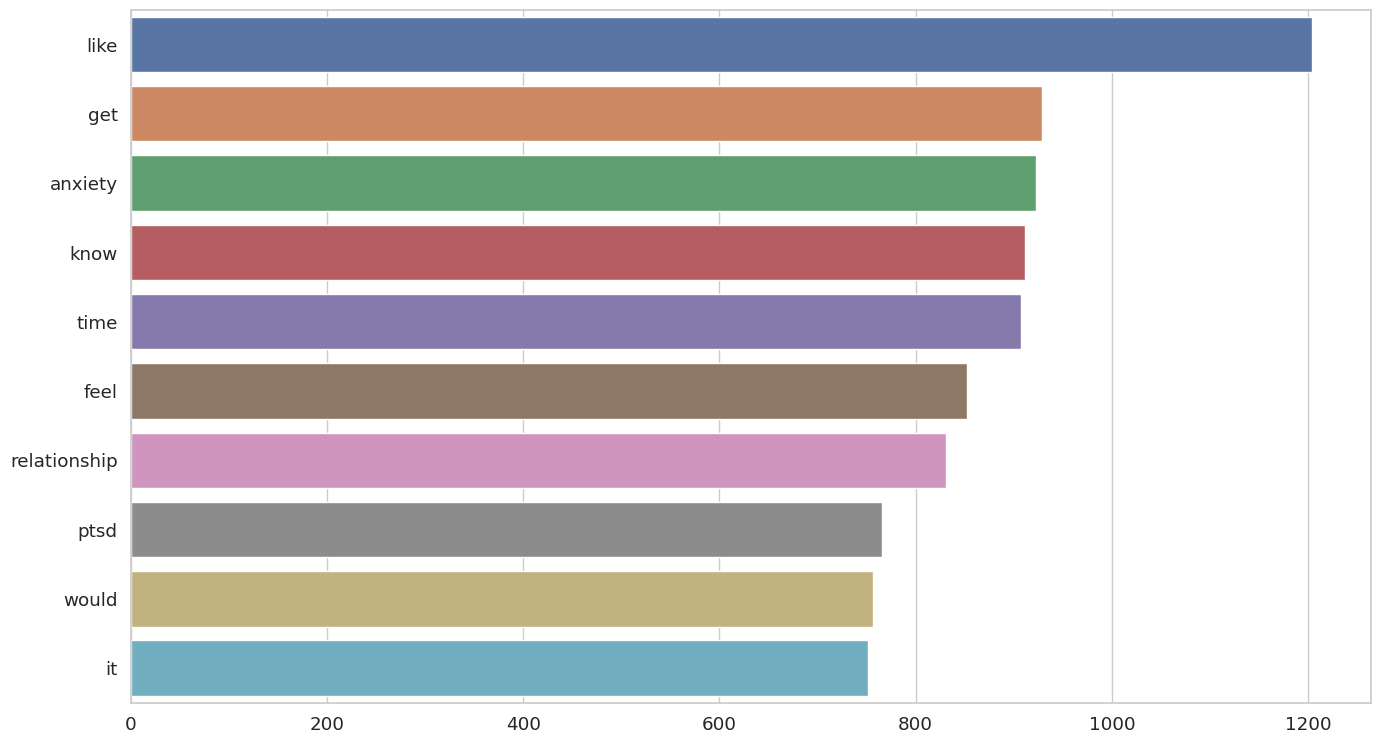

In [20]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(data.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

# **Bigram Analysis**

<AxesSubplot:>

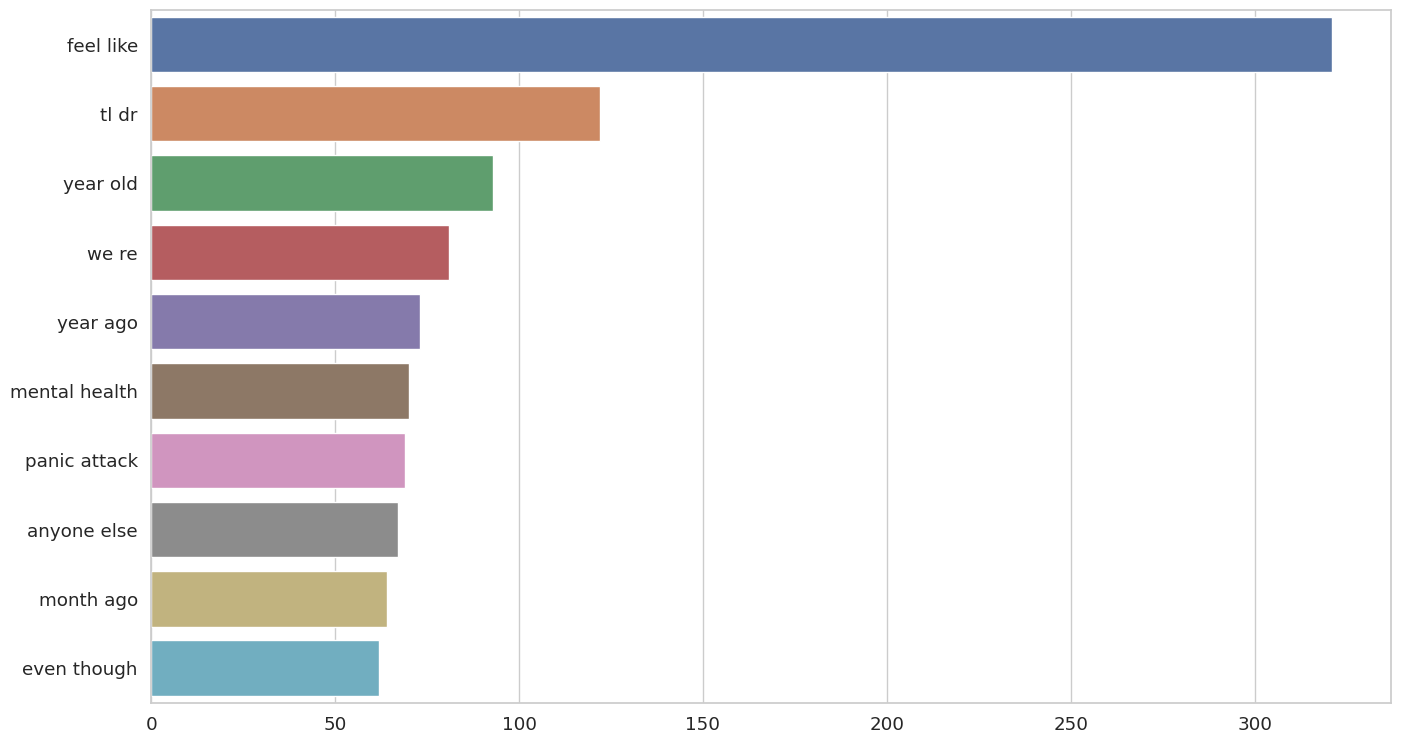

In [21]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

### Trigram Analysis

<AxesSubplot:>

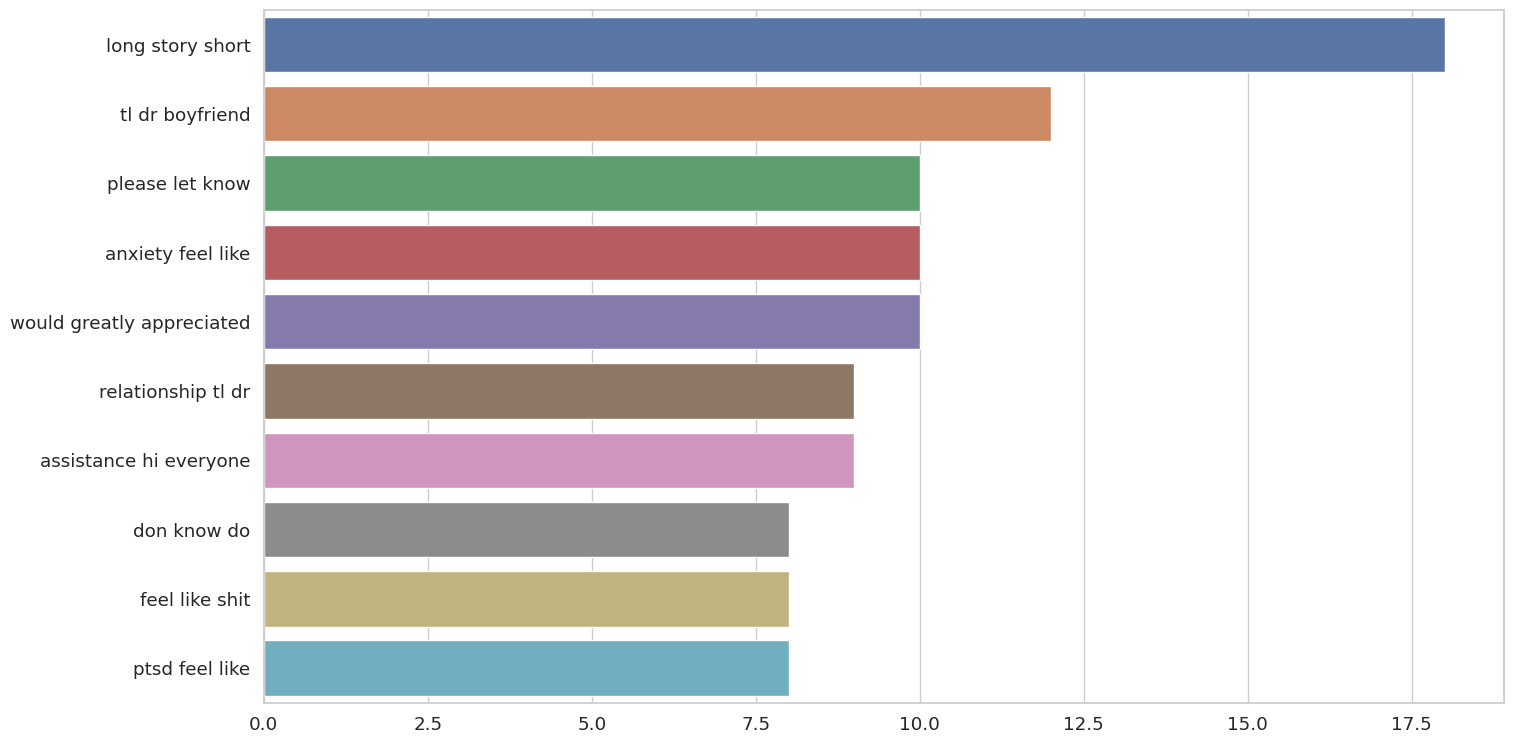

In [22]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(data.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

### Splitting the data into 2 parts - training and testing data

In [23]:
x_train,x_test,y_train,y_test = train_test_split(data.text,data.label,random_state = 0)

In [24]:
max_features = 10000
maxlen = 400

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 400, add padding to news with less than 300 words and truncating long ones**

In [25]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [26]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

# **Introduction to GloVe**
GloVe method is built on an important idea, You can derive semantic relationships between words from the co-occurrence matrix. Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.

In [27]:
EMBEDDING_FILE = '/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt'
#/kaggle/input/glove6b200d/glove.6B.200d.txt


In [28]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [29]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


**Some Model Parameters**

In [30]:
batch_size = 256
epochs = 10
embed_size = 200

In [31]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# **TRAINING THE MODEL**

In [32]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 400, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,219,969
Trainable params: 219,969
Non-trainable params: 2,000,000
_________________________________________________________________


In [34]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
9/9 [==============================] - 47s 4s/step - loss: 0.7620 - accuracy: 0.5216 - val_loss: 0.6779 - val_accuracy: 0.6014 - lr: 0.0100
Epoch 2/10
9/9 [==============================] - 39s 4s/step - loss: 0.6514 - accuracy: 0.6278 - val_loss: 0.6039 - val_accuracy: 0.6732 - lr: 0.0100
Epoch 3/10
9/9 [==============================] - 39s 4s/step - loss: 0.5885 - accuracy: 0.6880 - val_loss: 0.5648 - val_accuracy: 0.7451 - lr: 0.0100
Epoch 4/10
9/9 [==============================] - 38s 4s/step - loss: 0.5441 - accuracy: 0.7345 - val_loss: 0.5454 - val_accuracy: 0.7577 - lr: 0.0100
Epoch 5/10
9/9 [==============================] - 39s 4s/step - loss: 0.5013 - accuracy: 0.7707 - val_loss: 0.5254 - val_accuracy: 0.7239 - lr: 0.0100
Epoch 6/10
9/9 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.7852
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
9/9 [==============================] - 39s 4s/step - loss: 0.4665 - accuracy: 

# **ANALYSIS AFTER TRAINING OF MODEL**

In [35]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

67/67 [==============================] - 11s 158ms/step - loss: 0.3018 - accuracy: 0.8637
Accuracy of the model on Training Data is -  86.37217879295349 %
23/23 [==============================] - 4s 169ms/step - loss: 0.5247 - accuracy: 0.7662
Accuracy of the model on Testing Data is -  76.61972045898438 %


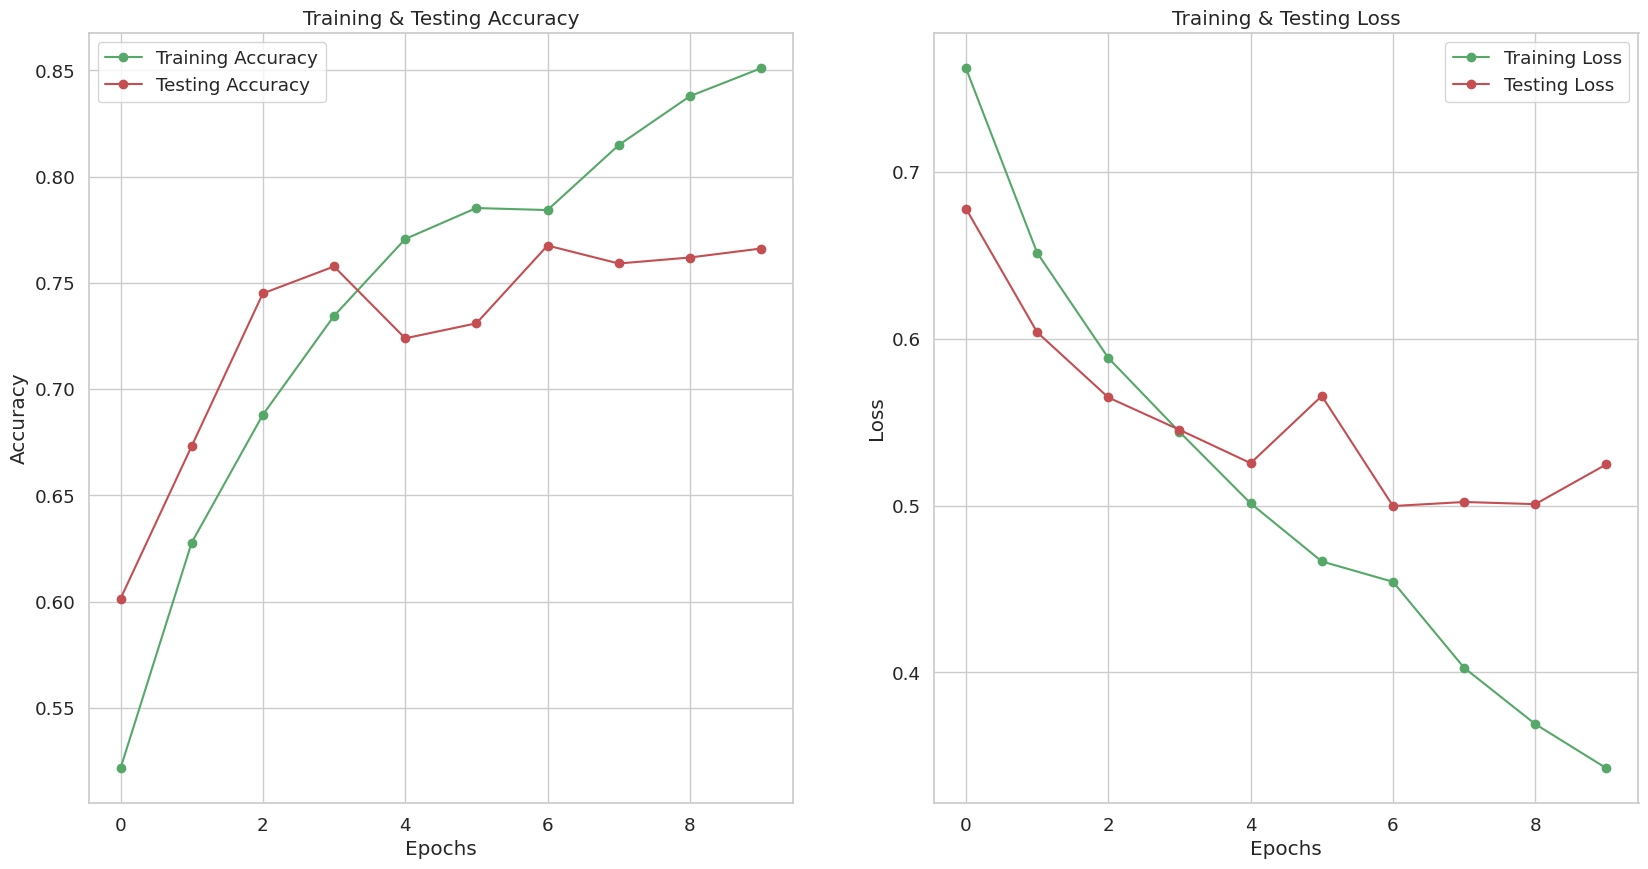

In [36]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [37]:
pred = (model.predict(X_test)>=0.5).astype(int)
pred[:5]

23/23 [==============================] - 4s 156ms/step


array([[0],
       [0],
       [0],
       [1],
       [0]])

In [38]:
print(classification_report(y_test, pred, target_names = ['Stressed','Not Stressed']))

              precision    recall  f1-score   support

    Stressed       0.73      0.81      0.77       336
Not Stressed       0.81      0.73      0.77       374

    accuracy                           0.77       710
   macro avg       0.77      0.77      0.77       710
weighted avg       0.77      0.77      0.77       710



In [39]:
cm = confusion_matrix(y_test,pred)
cm

array([[272,  64],
       [102, 272]])

In [40]:
cm = pd.DataFrame(cm , index = ['Stressed','Not Stressed'] , columns = ['Stressed','Not Stressed'])

Text(88.24999999999999, 0.5, 'Actual')

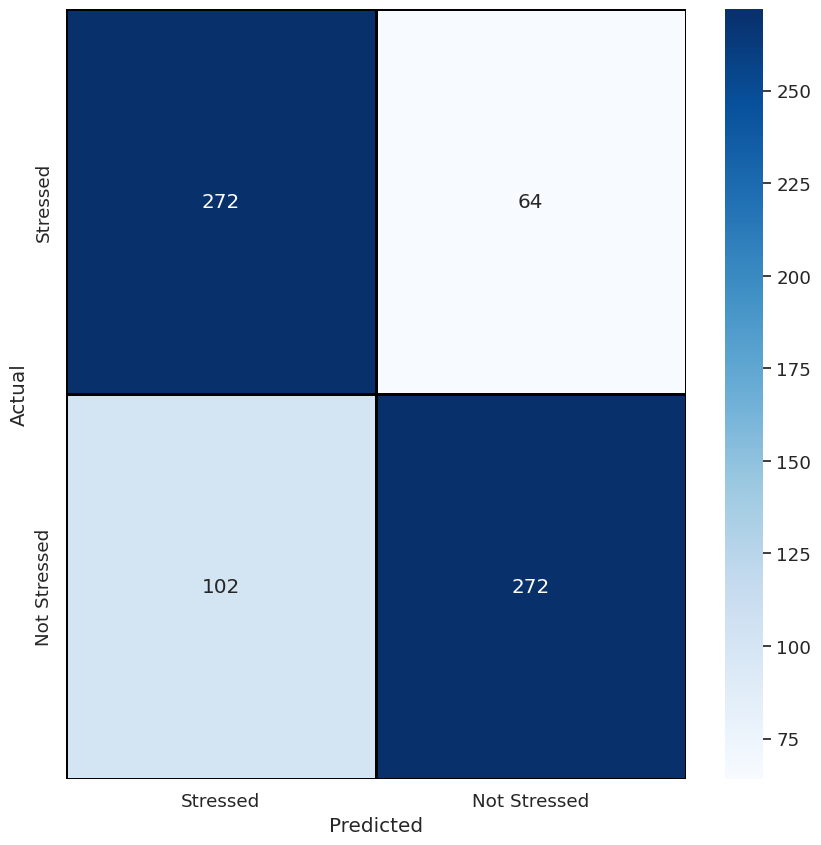

In [41]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Stressed','Not Stressed'] , yticklabels = ['Stressed','Not Stressed'])
plt.xlabel("Predicted")
plt.ylabel("Actual")